In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../..'))

from PySDM.physics import si
from PySDM.physics.formulae import volume
import numpy as np
from matplotlib import pyplot
from PySDM.physics.constants import rho_w

# 1. Gamma, Golovin

B = 5.78e3/1e6 cm^3/g/s

T = 60*1e6

Gamma distribution with mean = 0.33e-9 g, std dev = 0.33e-9 g

In [2]:
# Set desired constants
B      = 5.78e3/1e6 * si.cm**3 / si.g / si.s * rho_w
dt_sim = 1e5 * si.s      # time step
T_sim  = 60*1e6 * si.s   # total time of simulation
n_sd   = 2**14           # number of superdroplets
N0_perV = 1e4 / si.cm**3 # initial density: number / cm^3
N0     = 2e8             # initial number of droplets
V_sim  = N0 / N0_perV    # simulation box volume
end_step = int(T_sim / dt_sim)

# initial distribution
mean_particle_mass = 0.33e-9 * si.g
stdev_particle_mass = 0.33e-9 * si.g

# convert to volume
mean_particle_volume = mean_particle_mass / rho_w
stdev_particle_volume = stdev_particle_mass / rho_w

# get gamma distribution parameters
k_shape = (mean_particle_volume / stdev_particle_volume)**2
theta_scale = stdev_particle_volume**2/mean_particle_volume

In [3]:
from PySDM.initialisation.spectra import Gamma
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

# initial distribution
initial_spectrum = Gamma(norm_factor=N0, k=k_shape, theta=theta_scale)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

Text(0.5, 1.0, 'initial distribution')

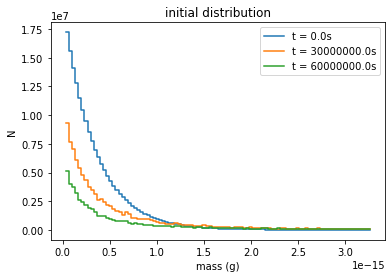

In [6]:
from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.backends import CPU
from PySDM.products.state import ParticlesNumberVolumeSpectrum, KMoments, KthMoment

# build the superdroplets
builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=V_sim))
builder.add_dynamic(Coalescence(kernel=Golovin(b = B)))
products = [ParticlesNumberVolumeSpectrum(), KMoments(), KthMoment()]
particles = builder.build(attributes, products)

# plot initial distribution
v_bins_edges = np.linspace((mean_particle_volume/10), (mean_particle_volume*10), num=100)
m_bins_edges = v_bins_edges * rho_w / si.g

for step in [0, int(end_step/2), end_step]:
    particles.run(step - particles.n_steps)
    pyplot.step(x=v_bins_edges[:-1],
                y=particles.products['N(v)'].get(v_bins_edges),#/particles.products['Mk'].get(0),
                where='post', label=f"t = {step*dt_sim}s")

pyplot.xlabel('mass (g)')
pyplot.ylabel("N")
pyplot.legend()
pyplot.title("initial distribution")

In [82]:
N_runs = 10
k_mom = 3

#[[initial moments 1, final moments 1],
#  initial moments 2, final moments 2], ...]

moments = np.zeros((N_runs, k_mom*2))

for run_num in range(N_runs):
    # reinitialize the SD
    builder = Builder(n_sd=n_sd, backend=CPU)
    builder.set_environment(Box(dt=dt_sim, dv=V_sim))
    builder.add_dynamic(Coalescence(kernel=Golovin(b=B)))
    products = [ParticlesNumberVolumeSpectrum(), KMoments()]
    particles = builder.build(attributes, products)
    
    # add the initial moments to the array
    step = 0
    particles.run(step - particles.n_steps)
    moments[run_num, 0:k_mom] = particles.products['M0-Mk'].get(k_mom)
    
    # add the final moments to the array
    step = end_step
    particles.run(step - particles.n_steps)
    moments[run_num, k_mom:2*k_mom] = particles.products['M0-Mk'].get(k_mom)
    
# convert moments to mass per cm^3
for i in range(k_mom):
    moments[:,i] *= ((rho_w / si.g)**i / (V_sim / si.cm**3))
    moments[:,i + k_mom] *= ((rho_w / si.g)**i / (V_sim / si.cm**3))

# save the data
np.savetxt('jan2021_test_1.out', moments, header="M0(0) #/cm3, M1(0) g/cm3, M2(0) g^2/cm3, M0(1) #/cm3, M1(1) g/cm3, M2(1) g^2/cm3")

In [80]:
moments

array([[9.99997440e+03, 3.29961404e-06, 2.17610199e-15, 3.19326785e+03,
        3.29961404e-06, 2.07628420e-14]])

## 2. Linear Kernel

A = 2.0e-6 / 1e6 cm^3/g/s
B = 2.0e3 / 1e6 cm^3/g/s

T = 60*1e6

Gamma distribution with mean = 0.33e-9 g, std dev = 0.33e-9 g

In [3]:
# Set desired constants
A      = 2.0e-6 / 1e6 * si.cm**3 / si.s
B      = 2.0e3  / 1e6 * si.cm**3 / si.g / si.s * rho_w
dt_sim = 1e5 * si.s      # time step
T_sim  = 60*1e6 * si.s   # total time of simulation
n_sd   = 2**14           # number of superdroplets
N0_perV = 1e4 / si.cm**3 # initial density: number / cm^3
N0     = 2e8             # initial number of droplets
V_sim  = N0 / N0_perV    # simulation box volume
end_step = int(T_sim / dt_sim)

# initial distribution
mean_particle_mass = 0.33e-9 * si.g
stdev_particle_mass = 0.33e-9 * si.g

# convert to volume
mean_particle_volume = mean_particle_mass / rho_w
stdev_particle_volume = stdev_particle_mass / rho_w

# get gamma distribution parameters
k_shape = (mean_particle_volume / stdev_particle_volume)**2
theta_scale = stdev_particle_volume**2/mean_particle_volume

Text(0.5, 1.0, 'initial distribution')

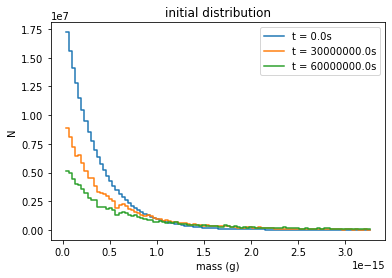

In [5]:
from PySDM.initialisation.spectra import Gamma
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

# initial distribution
initial_spectrum = Gamma(norm_factor=N0, k=k_shape, theta=theta_scale)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Linear
from PySDM.backends import CPU
from PySDM.products.state import ParticlesNumberVolumeSpectrum, KMoments, KthMoment

# build the superdroplets
builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=V_sim))
builder.add_dynamic(Coalescence(kernel=Linear(a=A, b=B)))
products = [ParticlesNumberVolumeSpectrum(), KMoments(), KthMoment()]
particles = builder.build(attributes, products)

# plot initial distribution
v_bins_edges = np.linspace((mean_particle_volume/10), (mean_particle_volume*10), num=100)
m_bins_edges = v_bins_edges * rho_w / si.g

for step in [0, int(end_step/2), end_step]:
    particles.run(step - particles.n_steps)
    pyplot.step(x=v_bins_edges[:-1],
                y=particles.products['N(v)'].get(v_bins_edges),#/particles.products['Mk'].get(0),
                where='post', label=f"t = {step*dt_sim}s")

pyplot.xlabel('mass (g)')
pyplot.ylabel("N")
pyplot.legend()
pyplot.title("initial distribution")

In [9]:
N_runs = 10
k_mom = 3

#[[initial moments 1, final moments 1],
#  initial moments 2, final moments 2], ...]

moments = np.zeros((N_runs, k_mom*2))

for run_num in range(N_runs):
    # reinitialize the SD
    builder = Builder(n_sd=n_sd, backend=CPU)
    builder.set_environment(Box(dt=dt_sim, dv=V_sim))
    builder.add_dynamic(Coalescence(kernel=Linear(a=A, b=B)))
    products = [ParticlesNumberVolumeSpectrum(), KMoments()]
    particles = builder.build(attributes, products)
    
    # add the initial moments to the array
    step = 0
    particles.run(step - particles.n_steps)
    moments[run_num, 0:k_mom] = particles.products['M0-Mk'].get(k_mom)
    
    # add the final moments to the array
    step = end_step
    particles.run(step - particles.n_steps)
    moments[run_num, k_mom:2*k_mom] = particles.products['M0-Mk'].get(k_mom)
    
# convert moments to mass per cm^3
for i in range(k_mom):
    moments[:,i] *= ((rho_w / si.g)**i / (V_sim / si.cm**3))
    moments[:,i + k_mom] *= ((rho_w / si.g)**i / (V_sim / si.cm**3))

# save the data
np.savetxt('jan2021_linear_1.out', moments, header="M0(0) #/cm3, M1(0) g/cm3, M2(0) g^2/cm3, M0(1) #/cm3, M1(1) g/cm3, M2(1) g^2/cm3")

# 3. Product kernel

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../..'))

from PySDM.physics import si
from PySDM.physics.formulae import volume
import numpy as np
from matplotlib import pyplot
from PySDM.physics.constants import rho_w

# Set desired constants
from PySDM.physics import si
A      = 0.00 
B      = 0.00
C      = 2.0e12 * si.cm**3 / si.g / si.g / si.s * rho_w * rho_w
dt_sim = 1 * si.s      # time step
T_sim  = 1200 * si.s   # total time of simulation
n_sd   = 2**14           # number of superdroplets
N0_perV = 1e4 / si.cm**3 # initial density: number / cm^3
N0     = 2e8             # initial number of droplets
V_sim  = N0 / N0_perV    # simulation box volume
end_step = int(T_sim / dt_sim)

# initial distribution
mean_particle_mass = 0.33e-9 * si.g
stdev_particle_mass = 0.33e-9 * si.g

# convert to volume
mean_particle_volume = mean_particle_mass / rho_w
stdev_particle_volume = stdev_particle_mass / rho_w

# get gamma distribution parameters
k_shape = (mean_particle_volume / stdev_particle_volume)**2
theta_scale = stdev_particle_volume**2/mean_particle_volume

from PySDM.initialisation.spectra import Gamma
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

# initial distribution
initial_spectrum = Gamma(norm_factor=N0, k=k_shape, theta=theta_scale)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

In [3]:
from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Product
from PySDM.backends import CPU
from PySDM.products.state import ParticlesNumberVolumeSpectrum, KMoments, KthMoment

# build the superdroplets
builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=V_sim))
builder.add_dynamic(Coalescence(kernel=Product(c=C)))
products = [ParticlesNumberVolumeSpectrum(), KMoments(), KthMoment()]
particles = builder.build(attributes, products)

# plot initial distribution
v_bins_edges = np.linspace((mean_particle_volume/10), (mean_particle_volume*10), num=100)
m_bins_edges = v_bins_edges * rho_w / si.g

for step in [0, int(end_step/2), end_step]:
    particles.run(step - particles.n_steps)
    pyplot.step(x=v_bins_edges[:-1],
                y=particles.products['N(v)'].get(v_bins_edges),#/particles.products['Mk'].get(0),
                where='post', label=f"t = {step*dt_sim}s")

pyplot.xlabel('mass (g)')
pyplot.ylabel("N")
pyplot.legend()
pyplot.title("initial distribution")

AttributeError: 'Product' object has no attribute 'register'

## 3b. Product + Linear kernel